In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [62]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')
ncdata_orig = netCDF4.Dataset(ncfile_orig)
ncfile = os.path.join(pvlib_abspath, 'data', 'wrfout_solar_d01_2011-01-24_01:00:00.nc')
ncdata = xr.open_dataset(ncfile)

In [63]:
ncdata

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
Data variables:
    lon                 (Time, south_north, west_east) float32 ...
    lat                 (Time, south_north, west_east) float32 ...
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north, west_east) float64 ...
    apparent_elevation  (Time, south_north, west_east) float64 ...
    elevation           (Time, south_north, west_east) float64 ...
    azimuth             (Time, south_north, west_east) float64 ...
    equation_of_time    (Time, south_north, west_east) float64 ...

In [64]:
# Create an xarray.Dataset from the wrf qurery_variables.
variables = {
            'lat': 'XLAT',
            'lon': 'XLONG', 
            }
ncdata = xr.Dataset.rename(ncdata, variables)
# ncdata = xr.Dataset.reset_coords(ncdata, ['south_north'], drop=True)
# ncdata = xr.Dataset.reset_coords(ncdata, ['west_east'], drop=True)
ncdata = xr.Dataset.set_coords(ncdata, ['XLONG'])
ncdata = xr.Dataset.set_coords(ncdata, ['XLAT'])
ncdata

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
    XLONG               (Time, south_north, west_east) float32 ...
    XLAT                (Time, south_north, west_east) float32 ...
Data variables:
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north, west_east) float64 ...
    apparent_elevation  (Time, south_north, west_east) float64 ...
    elevation           (Time, south_north, west_east) float64 ...
    azimuth             (Time, south_north, west_east) float64 ...
    equation_of_time    (Time, south_north, west_east) float64 ...

In [86]:
# Get the desired variable(s)
dni_orig = getvar(ncdata_orig, "SWDDNI", timeidx=14)

dni = ncdata.dni.sel(Time='2011-01-24T15:00:00')
ghi = ncdata.ghi.sel(Time='2011-01-24T15:00:00')
ghi = ghi / 1000

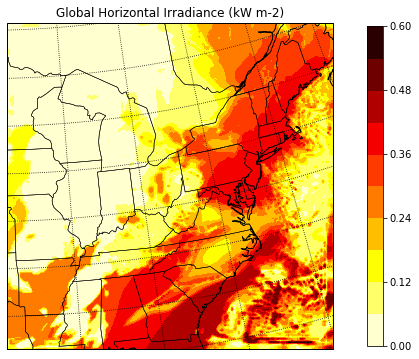

In [87]:
# Smooth the variable if it tends to be noisy 
# smooth_var = smooth2d(dni, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(dni_orig)

# Get the cartopy mapping object
cart_proj = get_cartopy(dni_orig)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(ghi), 10, colors="none",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(ghi), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(dni_orig))
ax.set_ylim(cartopy_ylim(dni_orig))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Global Horizontal Irradiance (kW m-2)")

fig_path = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/figures/GHI_plot.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')
plt.show()